# Testing Underdamped Langevin Inference of geodynamo ADM variations

In [1]:
from UnderdampedLangevinInference import underdampedlangevininference as uli
import numpy as np
import matplotlib.pyplot as plt

# Reproduce original

In [2]:
################################################################
# I. Prepare the data (here using a simulated model).

# Force field parameters (VdP oscillator)
dim = 1
initial_position = np.array([[0.1]]) 
mu = 2
force = lambda X,V : mu * (1-X**2)*V - X

# Diffusion parameters (constant noise)
diffusion = 1. * np.identity(dim) 


# Simulation parameters
dt = 0.02
oversampling = 10
prerun = 100
Npts = 1000
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

In [3]:
# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(1)
X = uli.UnderdampedLangevinProcess(
    force,
    diffusion,
    tlist,
    initial_position=initial_position,
    oversampling=oversampling,
    prerun=prerun
)

In [4]:
# Add artificial measurement noise:
noise_amplitude = 0.002
noise = noise_amplitude * np.random.normal(size=X.data.shape)

In [5]:
# The input of the inference method is the "xlist" array, which has
# shape Nsteps x 1 x dim (the middle index is used for multiple
# particles with identical properties; we do not use it in this demo).
# You can replace xlist and tlist with your own data!
xlist = X.data + noise
tlist = X.t

In [6]:
# We use a wrapper class, StochasticTrajectoryData, to format the data
# in a way that the inference methods can use.
data = uli.StochasticTrajectoryData(xlist,tlist) 
data_exact = uli.StochasticTrajectoryData(X.data,X.t,V=X.data_v) 

In [7]:
# Test numerical gradient
v_hat_diff = np.diff(data.X_ito[:,0,:], axis=0) / dt

Text(0.5,1,'Gradient')

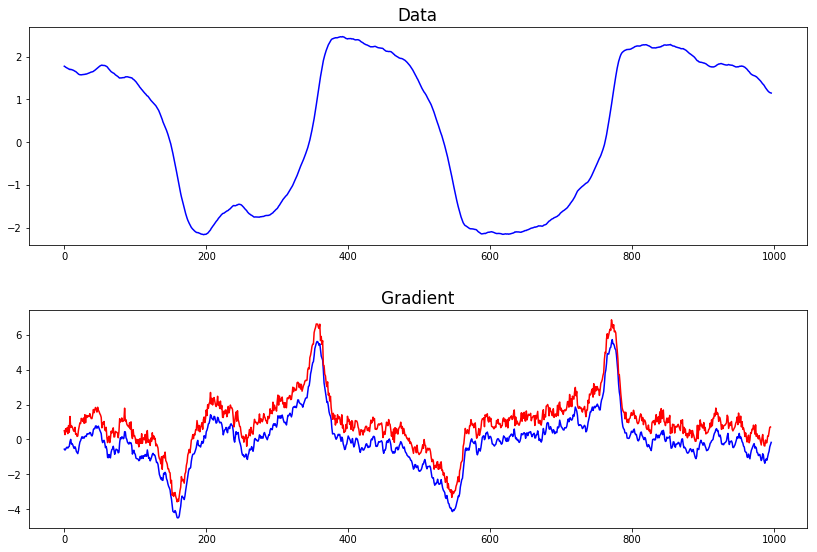

In [8]:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)

plt.subplot(2,1,1)
plt.plot(data.X_ito[:,0,:],color='b')
plt.title('Data')

plt.subplot(2,1,2)
plt.plot(data.v_hat[:,0,:],color='b')
plt.plot(v_hat_diff + 1,color='r')
plt.title('Gradient')

In [9]:
################################################################
# II. Perform inference.

S = uli.UnderdampedLangevinInference( data )

S.compute_current(basis = { 'type' : 'polynomial', 'order' : 3} ) 
S.compute_diffusion(method='noisy') 
S.compute_force()
S.compute_force_error() 

S.compare_to_exact(data_exact=data_exact, force_exact = force, D_exact = diffusion)
S.print_report()

Computing the force assuming constant diffusion.
Computing error assuming constant diffusion.
Expected mean squared error: 0.05386200970728026
Normalized mean squared error on F along trajectory: 0.05760042590925656
Normalized mean squared error on average D: 0.022834588186966428
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[1.17801056]]
Measurement noise covariance:
 [[4.48570651e-06]]


Text(0,0.5,'inferred F(x,v)')

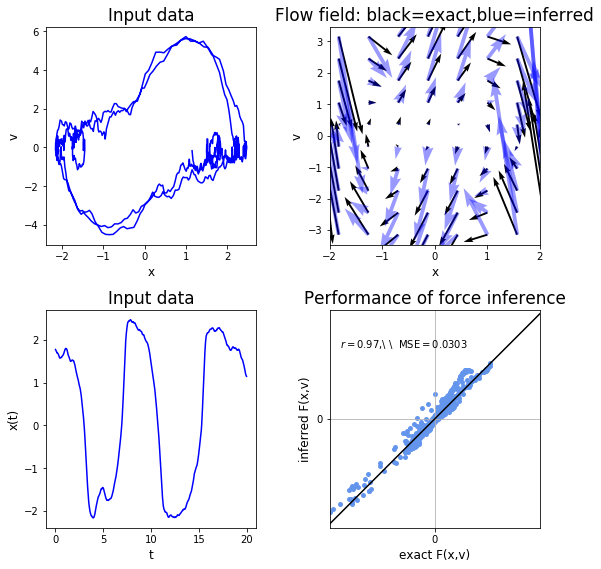

In [10]:
################################################################
# III. Plot the results and compare to exact fields.

# Prepare Matplotlib:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 2,3

pic_name = "ULI_demo_VdP.png"

# Plot the trajectory (xv phase space):
plt.subplot(H,W,1)
plt.plot(data.X_ito[:,0,:],data.v_hat[:,0,:],color='b')
plt.xlabel("x")
plt.ylabel("v")
plt.title("Input data")

# Plot the trajectory (x vs t):
plt.subplot(H,W,4)
plt.plot(data.t,data.X_ito[:,0,:],color='b')
plt.ylabel("x(t)")
plt.xlabel("t")
plt.title("Input data")

# Plot the force field - blue is inferred, black is the exact one used to generate the data.
plt.subplot(H,W,2)
S.data.plot_phase_space_forces(S.F_ansatz,color='b',alpha=0.4,zorder=0,width = 0.1,scale=0.2)
S.data.plot_phase_space_forces(force,color='k',alpha=1,zorder=-1,width=0.05,scale=0.2)
plt.xlabel("x")
plt.ylabel("v")
plt.xlim([-2,2])
plt.title("Flow field: black=exact,blue=inferred")

#Performance of force field inference
plt.subplot(H,W,5)
plt.title("Performance of force inference")
uli.ULI_plotting_toolkit.comparison_scatter(S.exact_F,S.ansatz_F,y=0.8,alpha=1)

plt.xlabel("exact F(x,v)")
plt.ylabel("inferred F(x,v)")

Simulating bootstrapped trajectory assuming constant diffusion.


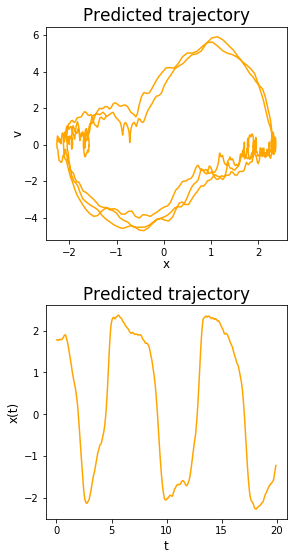

<Figure size 864x576 with 0 Axes>

In [11]:
# Use the inferred force and diffusion fields to simulate a new
# trajectory with the same times list, and plot it.
Y = S.simulate_bootstrapped_trajectory(oversampling=20)
data_bootstrap = uli.StochasticTrajectoryData(Y.data,Y.t)

plt.subplot(H,W,3)
plt.title("Predicted trajectory")
plt.plot(data_bootstrap.X_ito[:,0,:],data_bootstrap.v_hat[:,0,:],color='orange')

plt.xlabel("x",labelpad=0)
plt.ylabel("v",labelpad=0)

plt.subplot(H,W,6)
plt.title("Predicted trajectory")
plt.plot(data_bootstrap.t,data_bootstrap.X_ito[:,0,:],color='orange')

plt.ylabel("x(t)")
plt.xlabel("t")


plt.tight_layout()
plt.show()
plt.savefig(pic_name)

# Dynamo data

In [12]:
import scipy.io

In [13]:
!ls data

DipoleSourceC2.dat      DipoleSourceHF1.dat     DipoleSource_PADM2M.dat


In [24]:
filename = './data/DipoleSource_PADM2M.dat'

In [26]:
def get_dipole_data(filename, variablename):
    mat = scipy.io.loadmat(filename)
    arrays = mat.get(variablename)
    t = np.array(list(map(lambda x: x[0] ,arrays)))
    x = np.array(list(map(lambda x: x[1] ,arrays)))
    x = x - np.mean(x)
    dt = (t[1] - [0])[0]
    dxdt = np.diff(x) / dt
    I = np.cumsum(x) * dt
    t = t[:-1]
    x = x[:-1]
    I = I[:-1]
    return t, x, dxdt, I

t_dipole, x_dipole, dxdt_dipole, I_dipole = get_dipole_data(filename, 'DipoleSource_PADM2M')

Text(0.5,1,'Gradient')

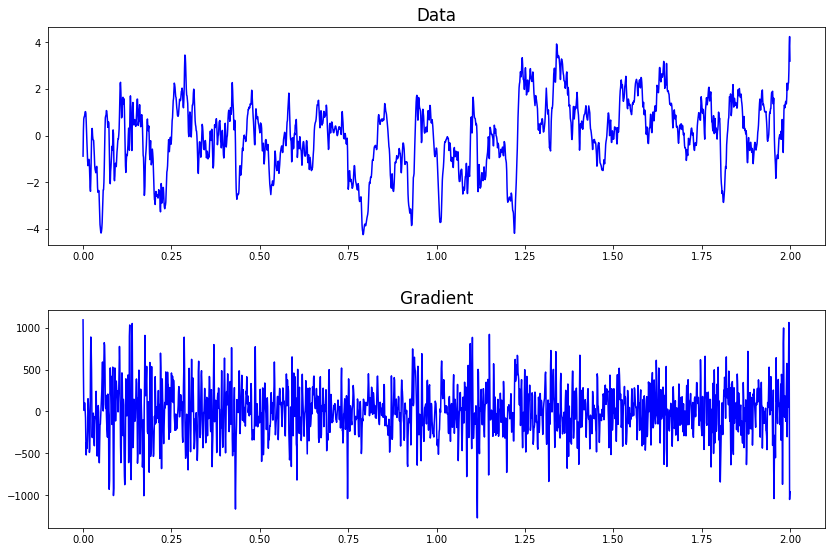

In [27]:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)

plt.subplot(2,1,1)
plt.plot(t_dipole, x_dipole,color='b')
plt.title('Data')

plt.subplot(2,1,2)
plt.plot(t_dipole, dxdt_dipole,color='b')
plt.title('Gradient')

Text(0.5,1,'Gradient')

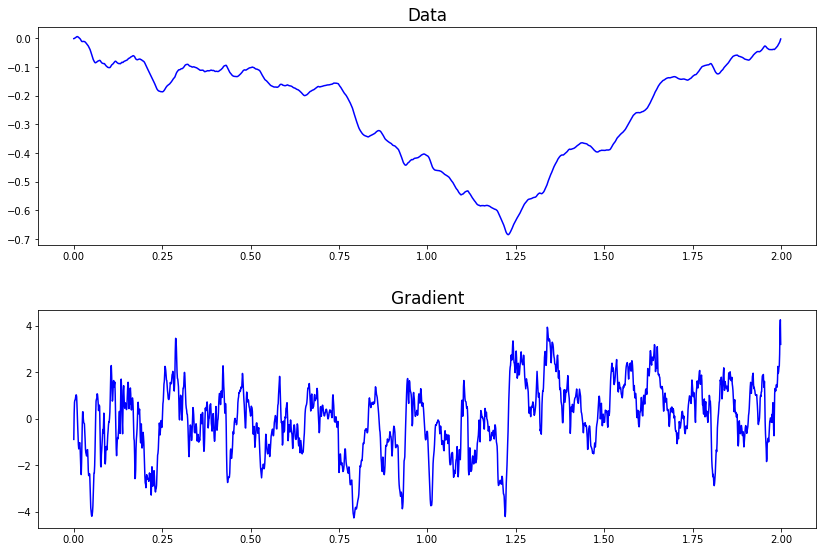

In [28]:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)

plt.subplot(2,1,1)
plt.plot(t_dipole, I_dipole,color='b')
plt.title('Data')

plt.subplot(2,1,2)
plt.plot(t_dipole, x_dipole,color='b')
plt.title('Gradient')

Text(0.5,1,'Dynamo, (I,x)')

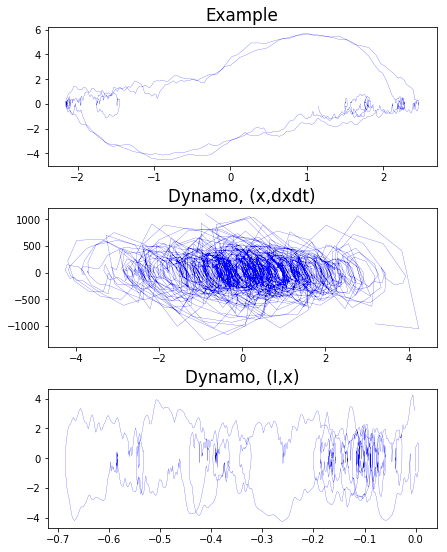

In [29]:
fig_size = [6,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)

plt.subplot(3,1,1)
plt.plot(data.X_ito[:,0,:],data.v_hat[:,0,:],color='b',lw=0.2)
plt.title('Example')

plt.subplot(3,1,2)
plt.plot(x_dipole, dxdt_dipole,color='b',lw=0.2)
plt.title('Dynamo, (x,dxdt)')

plt.subplot(3,1,3)
plt.plot(I_dipole, x_dipole,color='b',lw=0.2)
plt.title('Dynamo, (I,x)')



## Perform inference on dynamo data

In [30]:
################################################################
# II. Perform inference.

xlist_dynamo = np.reshape(I_dipole, (len(I_dipole), 1, 1))
tlist_dynamo = t_dipole

data_dynamo = uli.StochasticTrajectoryData(xlist_dynamo,tlist_dynamo) 
S_dynamo = uli.UnderdampedLangevinInference( data_dynamo )

S_dynamo.compute_current(basis = { 'type' : 'polynomial', 'order' : 3} ) 
S_dynamo.compute_diffusion(method='noisy') 
S_dynamo.compute_force()
S_dynamo.compute_force_error() 

S_dynamo.print_report()

Computing the force assuming constant diffusion.
Computing error assuming constant diffusion.
Expected mean squared error: 0.21730831727271005
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[86.72630844]]
Measurement noise covariance:
 [[-5.05394453e-09]]


Compare with example output:
```
Computing the force assuming constant diffusion.
Computing error assuming constant diffusion.
Expected mean squared error: 0.05386200970728026
Normalized mean squared error on F along trajectory: 0.05760042590925656
Normalized mean squared error on average D: 0.022834588186966428
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[1.17801056]]
Measurement noise covariance:
 [[4.48570651e-06]]
```

## III. Plot the results and compare to exact fields.

Text(0.5,1,'Flow field: blue=inferred')

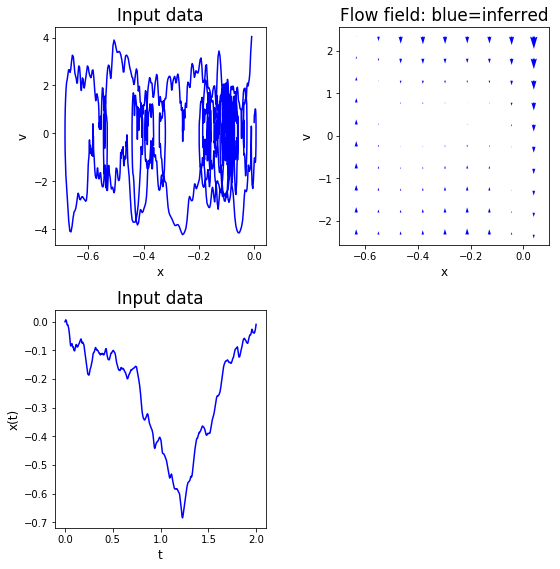

In [39]:
# Prepare Matplotlib:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 2,3

pic_name = "ULI_demo_VdP.png"

# Plot the trajectory (xv phase space):
plt.subplot(H,W,1)
plt.plot(data_dynamo.X_ito[:,0,:],data_dynamo.v_hat[:,0,:],color='b')
plt.xlabel("x")
plt.ylabel("v")
plt.title("Input data")

# Plot the trajectory (x vs t):
plt.subplot(H,W,4)
plt.plot(data_dynamo.t,data_dynamo.X_ito[:,0,:],color='b')
plt.ylabel("x(t)")
plt.xlabel("t")
plt.title("Input data")

# Plot the force field - blue is inferred, black is the exact one used to generate the data.
plt.subplot(H,W,2)
S_dynamo.data.plot_phase_space_forces(S_dynamo.F_ansatz,color='b',zorder=0,width = 100,scale=0.001)
plt.xlabel("x")
plt.ylabel("v")
plt.xlim([-0.7,0.1])
plt.title("Flow field: blue=inferred")


# Alternate choices

In [32]:
################################################################
# II. Perform inference.

xlist_dynamo2 = np.reshape(x_dipole, (len(I_dipole), 1, 1))
tlist_dynamo2 = t_dipole

data_dynamo2 = uli.StochasticTrajectoryData(xlist_dynamo2,tlist_dynamo2) 
S_dynamo2 = uli.UnderdampedLangevinInference( data_dynamo2 )

S_dynamo2.compute_current(basis = { 'type' : 'polynomial', 'order' : 3} ) 
S_dynamo2.compute_diffusion(method='noisy') 
S_dynamo2.compute_force()
S_dynamo2.compute_force_error() 

S_dynamo2.print_report()

Computing the force assuming constant diffusion.
Computing error assuming constant diffusion.
Expected mean squared error: 0.012300956089153343
             
  --- StochasticForceInference report --- 
Average diffusion tensor:
 [[49927090.05101611]]
Measurement noise covariance:
 [[0.00089348]]


Text(0.5,1,'Flow field: blue=inferred')

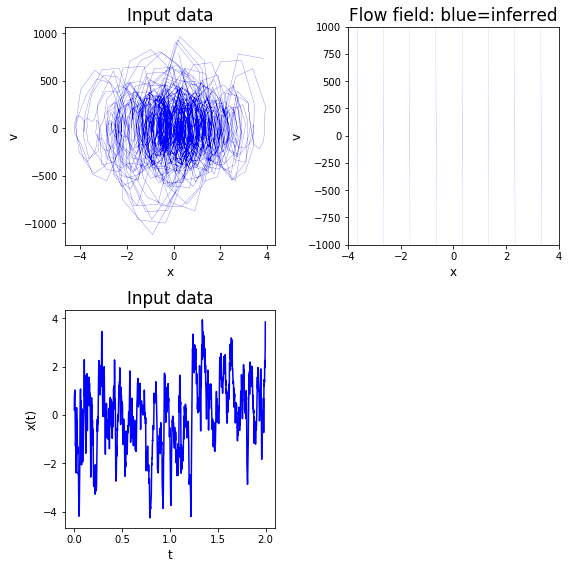

In [47]:
# Prepare Matplotlib:
fig_size = [12,8]
params = {'axes.labelsize': 12,
          'font.size':   14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'figure.figsize': fig_size,
          }
plt.rcParams.update(params)
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(left=0.06, bottom=0.07, right=0.96, top=0.94, wspace=0.35, hspace=0.3)
H,W = 2,3

pic_name = "ULI_demo_VdP.png"

# Plot the trajectory (xv phase space):
plt.subplot(H,W,1)
plt.plot(data_dynamo2.X_ito[:,0,:],data_dynamo2.v_hat[:,0,:],color='b',lw=0.2)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Input data")

# Plot the trajectory (x vs t):
plt.subplot(H,W,4)
plt.plot(data_dynamo2.t,data_dynamo2.X_ito[:,0,:],color='b')
plt.ylabel("x(t)")
plt.xlabel("t")
plt.title("Input data")

# Plot the force field - blue is inferred, black is the exact one used to generate the data.
plt.subplot(H,W,2)
S_dynamo2.data.plot_phase_space_forces(S_dynamo2.F_ansatz,color='b',zorder=0,width = 0.1,scale=10)
plt.xlabel("x")
plt.ylabel("v")
plt.xlim([-4,4])
plt.ylim([-1000,1000])
plt.title("Flow field: blue=inferred")